# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [57]:
from math import sqrt
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from PIL import Image
py.init_notebook_mode(connected=True)
%matplotlib inline
pd.options.display.expand_frame_repr = False

#### Read data set

In [58]:
data = pd.read_excel('USD copy.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5949 entries, 0 to 5948
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    5949 non-null   datetime64[ns]
 1   curs    5949 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 93.1 KB


In [59]:
data = data.sort_values(by='data')
data.head()

,data,curs
5948,2000-01-01,27.00
5947,2000-01-06,26.90
5946,2000-01-07,27.23
5945,2000-01-11,27.73
5944,2000-01-12,28.44


#### Plot line graph base on `Weighted Price`

In [60]:
# Заполняем NaN предыдущим значением
data = data.drop(data.index[:10])

columns = data.columns
for column in columns:
    data[column].replace(0, np.nan, inplace=True)
    data[column].fillna(method='ffill', inplace=True)

btc_trace = go.Scatter(x=data['data'], y=data['curs'], name= 'Price')
py.iplot([btc_trace])

/tmp/ipykernel_12028/3354046346.py:7: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



#### Function to convert series to supervised learning

In [61]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [62]:
columns = ['data', 'curs']

reframed = pd.DataFrame(columns=columns)

scaler_mas = []

for column in columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    item = data[column].values.reshape(-1,1)
    item = item.astype('float32')
    item = scaler.fit_transform(item)
    reframed[column] = item.reshape(-1)
    scaler_mas.append(scaler)

print(reframed.tail())
values = reframed.values

          data      curs
5934  0.999542  0.691914
5935  0.999657  0.688529
5936  0.999771  0.691805
5937  0.999886  0.705178
5938  1.000000  0.707571


#### Split 70% of data for training and 30% for testing

In [63]:
train_size = int(len(values) * 0.7)
train, test = values[0:train_size], values[train_size::]

#### Create function for creating dataset with look back

In [64]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        dataX.append(dataset[i-look_back:i])
        dataY.append([dataset[i][0]])
    return np.array(dataX), np.array(dataY)


#### Generate dataset for trainX, trainY, testX, testY

In [65]:
lb = 1
trainX, trainY = create_dataset(train, lb)
testX, testY = create_dataset(test, lb)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(4156, 1, 2) (4156, 1) (1781, 1, 2) (1781, 1)


#### Running the LSTM model with 300 epochs

In [66]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, verbose=0, shuffle=False, validation_data=(testX, testY))

#### Plot line graph to show amount loss according the epoch

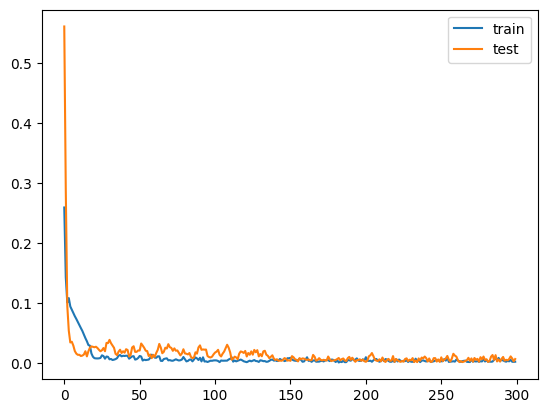

In [67]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using testX and plotting line graph against testY

56/56 [==============================] - 0s 2ms/step
1781


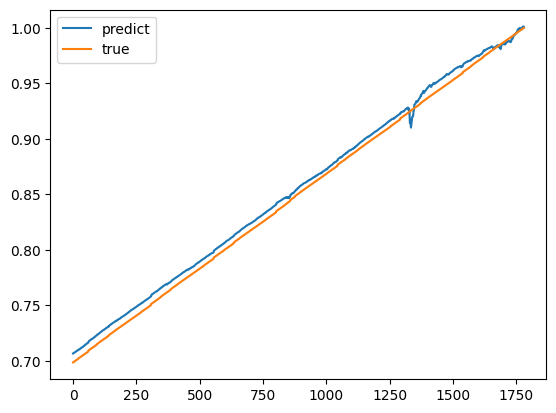

In [68]:
yhat = model.predict(testX)
print(len(yhat))
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [69]:
testY_inverse = scaler_mas[0].inverse_transform(testY)
yhat_inverse = scaler_mas[0].inverse_transform(yhat)

#### RMSE

In [70]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 4849623354035522.0


#### Convert X to dates

In [71]:
predictDates = data.tail(len(testX)).data

#### Plot line graph with Y as USD

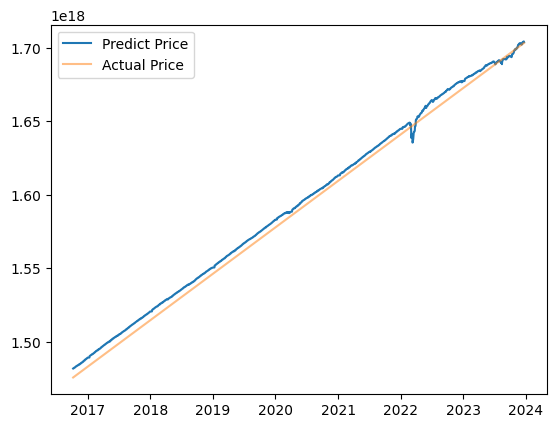

In [72]:
pyplot.plot(predictDates, yhat_inverse, label='Predict Price')
pyplot.plot(predictDates, testY_inverse, label='Actual Price', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Reshape testY and yhat for plotly

In [73]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [74]:
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
py.iplot([predict_chart, actual_chart])